# Modeling and Simulation in Python

Chapter 5: Design

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
init = StateVector([])
init['S'] = 90
init['I'] = 1
init['R'] = 0
init

S    90
I     1
R     0
dtype: int64

In [3]:
init = StateVector([90, 1, 0], index=['S', 'I', 'R'])
init

S    90
I     1
R     0
dtype: int64

In [4]:
init /= np.sum(init)
init

S    0.989011
I    0.010989
R    0.000000
dtype: float64

In [5]:
def make_system(beta, gamma, init=init):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [6]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)

In [7]:
def update1(system, state):
    """Update the SIR model.
    
    system: System object
    state: StateVector (s, i, r)
    
    returns: StateVector (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return StateVector([s, i, r], index=state.index)

In [8]:
state = update1(sir, init)
state

S    0.985388
I    0.011865
R    0.002747
dtype: float64

In [9]:
def run_model(system, update_func):
    state = system.init
    for i in range(system.t0, system.t_end):
        state = update_func(system, state)
    return state

In [10]:
run_model(sir, update1)

S    0.520819
I    0.000676
R    0.478505
dtype: float64

### Using Series objects

In [11]:
def run_model(system, update_func):
    S = TimeSeries([])
    I = TimeSeries([])
    R = TimeSeries([])

    state = system.init
    S[0], I[0], R[0] = state
    
    for i in range(sir.t0, sir.t_end):
        state = update_func(system, state)
        S[i+1], I[i+1], R[i+1] = state
    
    system.S = S
    system.I = I
    system.R = R

In [12]:
sir = make_system(beta, gamma)
run_model(sir, update1)

In [13]:
def plot_results(S, I, R):
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Saving figure to file chap05-fig01.pdf


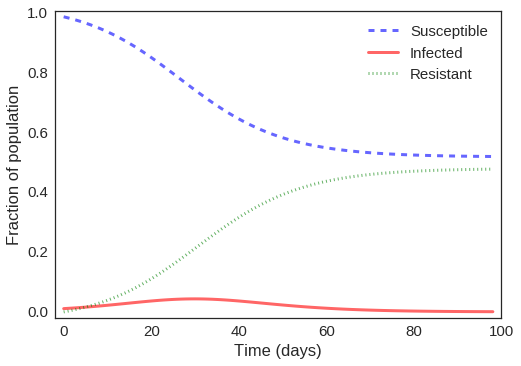

In [14]:
plot_results(sir.S, sir.I, sir.R)
savefig('chap05-fig01.pdf')

### Using a DataFrame

In [15]:
def run_model(system, update_func):
    df = DataFrame(columns=['S', 'I', 'R'])
    df.loc[0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

In [16]:
sir = make_system(beta, gamma)
run_model(sir, update1)
sir.results.head()

,S,I,R
0,0.989011,0.010989,0.000000
1,0.985388,0.011865,0.002747
2,0.981491,0.012795,0.005713
3,0.977305,0.013783,0.008912
4,0.972815,0.014827,0.012358


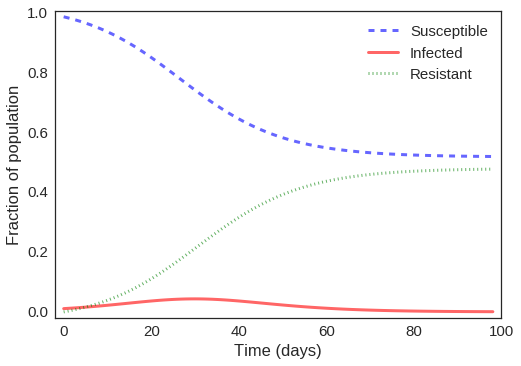

In [17]:
df = sir.results
plot_results(df.S, df.I, df.R)

### Metrics

In [18]:
def calc_total_infected(system):
    df = system.results
    return df.S[system.t0] - df.S[system.t_end]

In [19]:
sir.beta, calc_total_infected(sir)

(0.3333333333333333, 0.46819207410177399)

In [20]:
sir.beta = 0.333
sir.gamma = 0.25
run_model(sir, update1)
print(sir.beta, sir.gamma, calc_total_infected(sir))

0.333 0.25 0.467032714017


In [21]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [22]:
for beta in beta_array:
    sir = make_system(beta, gamma)
    run_model(sir, update1)
    print(sir.beta, calc_total_infected(sir))

0.1 0.00715333115128
0.18 0.0260059625153
0.26 0.159841671698
0.34 0.490761020417
0.42 0.689903615047
0.5 0.804583645575
0.58 0.8737068587
0.66 0.916660636786
0.74 0.943841720738
0.82 0.961176498583
0.9 0.972217579652


### What if?

In [24]:
observed_fraction_infected = 0.3

c = 1.2
gamma = 1 / 4
beta = c * gamma 

sir = make_system(beta, gamma)
sir.beta, sir.gamma

(0.3, 0.25)

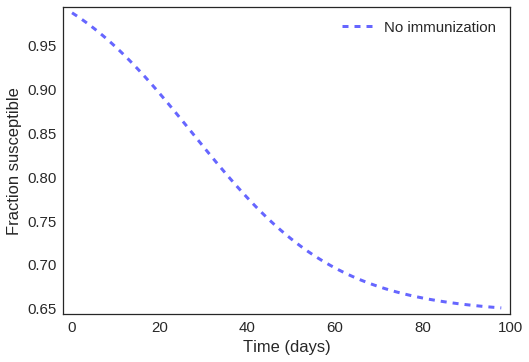

In [25]:
run_model(sir, update1)
plot(sir.results.S, '--', color='blue', label='No immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

In [26]:
calc_total_infected(sir)

0.33666563173764197

In [27]:
def immunize(system, fraction):
    s, i, r = system.init
    s -= fraction
    r += fraction
    system.init = s, i, r

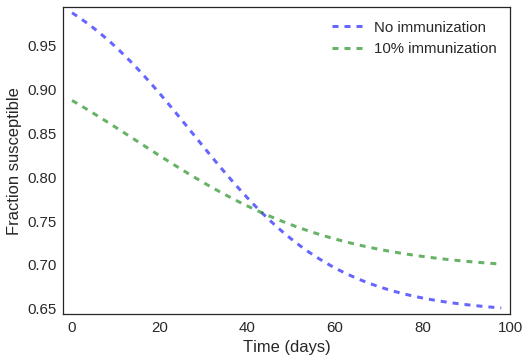

In [28]:
sir2 = make_system(beta, gamma)
immunize(sir2, 0.1)
run_model(sir2, update1)
plot(sir.results.S, '--', color='blue', label='No immunization')
plot(sir2.results.S, '--', color='green', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

In [29]:
calc_total_infected(sir2)

0.18665307678471343

In [30]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    sir = make_system(beta, gamma)
    immunize(sir, fraction)
    run_model(sir, update1)
    print(fraction, calc_total_infected(sir))

0.0 0.336665631738
0.1 0.186653076785
0.2 0.0886085056892
0.3 0.0439958322587
0.4 0.0247367945899
0.5 0.0150655109183
0.6 0.00941950556391
0.7 0.00575381715979
0.8 0.0031921546323
0.9 0.00130469419207
1.0 -0.000142240931426


In [31]:
def sweep_immunity(immunize_array):
    series = Series([])
    for fraction in immunize_array:
        sir = make_system(beta, gamma)
        immunize(sir, fraction)
        run_model(sir, update1)
        series[fraction] = calc_total_infected(sir)
    return series

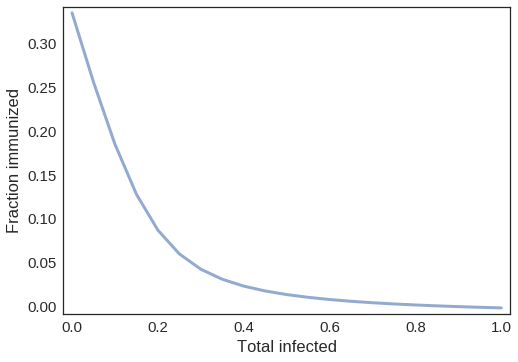

In [32]:
immunize_array = linspace(0, 1, 21)
infected = sweep_immunity(immunize_array)
plot(infected)

decorate(xlabel='Total infected',
         ylabel='Fraction immunized',
         legend=False)